In [1]:
import os
import cbclib as cbc
import numpy as np
# import jax
# import jax.numpy as jnp
import sys
import hdf5plugin
import h5py
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider
from pickle import load, dump
from cbclib.src import draw_line_table, fft_convolve, local_maxima, median

from scripts.cbsd_numpy import (generate_line, region_grow, Structure, log_nfa,
                                find_streaks, DetState, Image)

In [2]:
frames = np.load('results/frames.npz')['data']

In [15]:
from cbclib.streak_finder import Pattern

struct = cbc.src.Structure(4, 4)
data = frames[5]
mask = np.any(frames != 0.0, axis=0)

pattern = Pattern(data, mask, struct)

In [19]:
peaks = pattern.find_peaks(1.2, 10)
peaks

<Peaks, points.shape = (1837, 2)>

In [55]:
lines = pattern.find_streaks(peaks, xtol=2.6, vmin=1.0, lookahead=3, min_size=2)

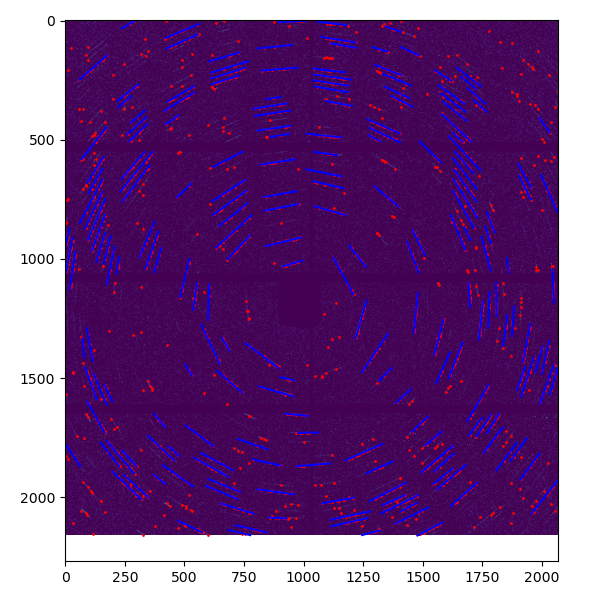

In [56]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(data, vmin=0.0, vmax=10.0)
ax.scatter(peaks.x, peaks.y, c='r', s=1)

for line in lines:
    ax.plot(line[::2], line[1::2], c='b')

fig.tight_layout()
plt.show()

In [39]:
struct = Structure.new(radius=2, rank=2)
image = Image.new(data, struct)

In [40]:
idx = 230
x, y = 548, 1137
# x, y = peaks.x[idx], peaks.y[idx]
xtol, vmin = 1.2, 0.8

In [41]:
%time line = region_grow(x, y, image, 50, xtol, vmin, lookahead=1)

CPU times: user 33.7 ms, sys: 114 µs, total: 33.8 ms
Wall time: 33.1 ms


In [42]:
line2 = cbc.src.test_grow(x, y, data, mask, cbc.src.Structure(4, 4), 2.6, 0.5, 50, lookahead=3)
line2

[558.4394801179765, 1052.5258979845141, 537.0876821130632, 1212.8785200579432]

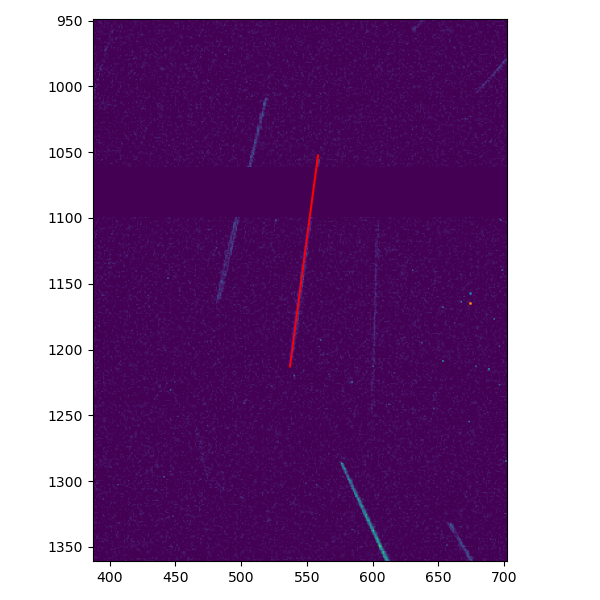

In [43]:
%matplotlib widget
offset = 150

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image.data[()], vmin=0.0, vmax=30)
# ax.scatter(points[0, 1], points[0, 0], c='r')
# ax.scatter(line.pixels.x, line.pixels.y, s=3, alpha=0.5, c='r')

ax.plot([line.bounds.x0, line.bounds.x1], [line.bounds.y0, line.bounds.y1], c='b')
ax.plot(line2[::2], line2[1::2], c='r')

ax.scatter(674, 1157, s=1)
ax.scatter(674, 1165, s=1)

ax.set_ylim(max(line.bounds.y0, line.bounds.y1) + offset,
            min(line.bounds.y0, line.bounds.y1) - offset)
ax.set_xlim(min(line.bounds.x0, line.bounds.x1) - offset,
            max(line.bounds.x0, line.bounds.x1) + offset)
fig.tight_layout()
plt.show()

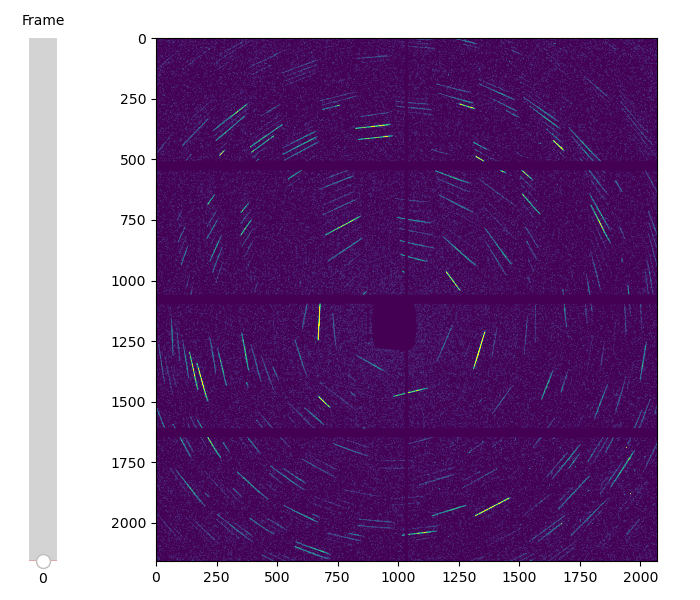

In [3]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'width_ratios': [0.1, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=frames.shape[0],
                valstep=np.arange(0, frames.shape[0]),
                valinit=0, orientation="vertical")

im = ax[1].imshow(frames[0], vmin=0.0, vmax=5.0)

def update(val):
    im.set_data(frames[slider.val])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()
plt.show()

In [4]:
index = 18
radius, rank = 2, 3

data = cbc.src.median_filter(frames[index], (3, 3))
# data = frames[index]
data = np.abs(data)
struct = Structure.new(radius, rank)

image = Image.new(data, struct)

In [55]:
xtol, vmin = 1.0, 0.8

# x, y = 1153, 1057
x, y = 1831, 1410
# x, y = 1514, 1262

%time line = region_grow(x, y, image, 200, xtol, vmin, lookahead=1)
# %time x, y, val = cbc.src.draw_line_table(line.bounds.to_line(2 * struct.radius + 1), image.shape, profile='tophat')
# %time image.update(struct, x, y, val)
# x, y = 1750, 660
# x, y = 1862, 1296

# %time line = region_grow(x, y, image, 200, xtol)

CPU times: user 93.2 ms, sys: 3.16 ms, total: 96.4 ms
Wall time: 90.7 ms


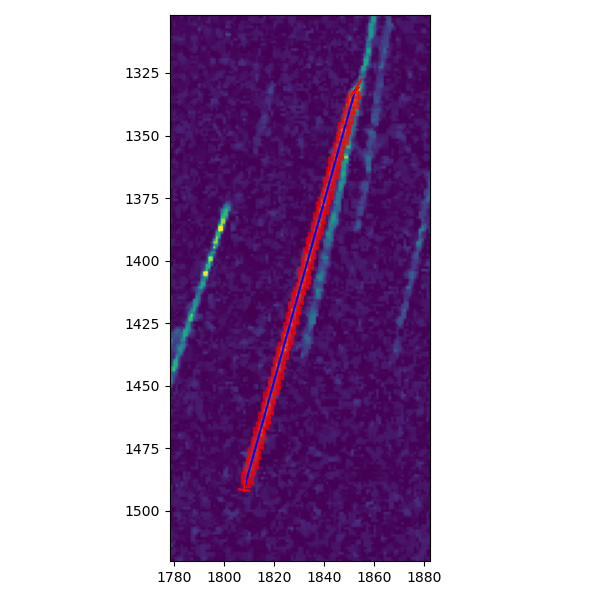

In [56]:
fline = generate_line(int(np.round(line.bounds.x0)), int(np.round(line.bounds.y0)),
                      image, struct.idxs)
fline2 = generate_line(int(np.round(line.bounds.x0 - np.cos(line.bounds.theta) * (radius + 0.5))),
                       int(np.round(line.bounds.y0 - np.sin(line.bounds.theta) * (radius + 0.5))),
                       image, struct.idxs)
bline = generate_line(int(np.round(line.bounds.x1)), int(np.round(line.bounds.y1)),
                         image, struct.idxs)
bline2 = generate_line(int(np.round(line.bounds.x1 + np.cos(line.bounds.theta) * (radius + 0.5))),
                       int(np.round(line.bounds.y1 + np.sin(line.bounds.theta) * (radius + 0.5))),
                       image, struct.idxs)

%matplotlib widget
offset = 30

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image.data[()], vmin=0.0, vmax=10)
ax.scatter(line.pixels.x, line.pixels.y, s=3, alpha=0.5, c='r')

ax.plot([line.bounds.x0, line.bounds.x1], [line.bounds.y0, line.bounds.y1], c='b')
ax.plot([fline.bounds.x0, fline.bounds.x1], [fline.bounds.y0, fline.bounds.y1], c='r')
ax.plot([fline2.bounds.x0, fline2.bounds.x1], [fline2.bounds.y0, fline2.bounds.y1], c='r')
ax.plot([bline.bounds.x0, bline.bounds.x1], [bline.bounds.y0, bline.bounds.y1], c='r')
ax.plot([bline2.bounds.x0, bline2.bounds.x1], [bline2.bounds.y0, bline2.bounds.y1], c='r')

ax.set_ylim(max(line.bounds.y0, line.bounds.y1) + offset,
            min(line.bounds.y0, line.bounds.y1) - offset)
ax.set_xlim(min(line.bounds.x0, line.bounds.x1) - offset,
            max(line.bounds.x0, line.bounds.x1) + offset)
fig.tight_layout()
plt.show()

In [4]:
from copy import deepcopy

index = 18
radius, rank = 2, 3
struct = Structure.new(radius=radius, rank=rank)

data = frames[index]
# data = cbc.src.median_filter(frames[index], (3, 3))
new_image = Image.new(np.clip(data, 0.0, np.inf), struct)
# new_image = Image.new(np.abs(data), struct)

In [25]:
image = deepcopy(new_image)

In [26]:
state = DetState.new_sparse(image, axis=1)

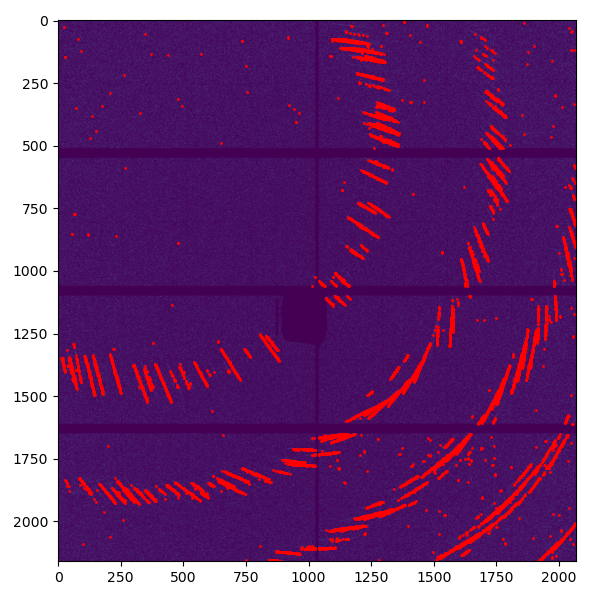

In [27]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image.data[()], vmin=0, vmax=10)
ax.scatter(state.x, state.y, s=1, c='r')

fig.tight_layout()
plt.show()

In [28]:
state = find_streaks(image, state, xtol=1.1, lookahead=2, min_size=5)

Detecting lines: 0 checked [00:00, ?it/s]

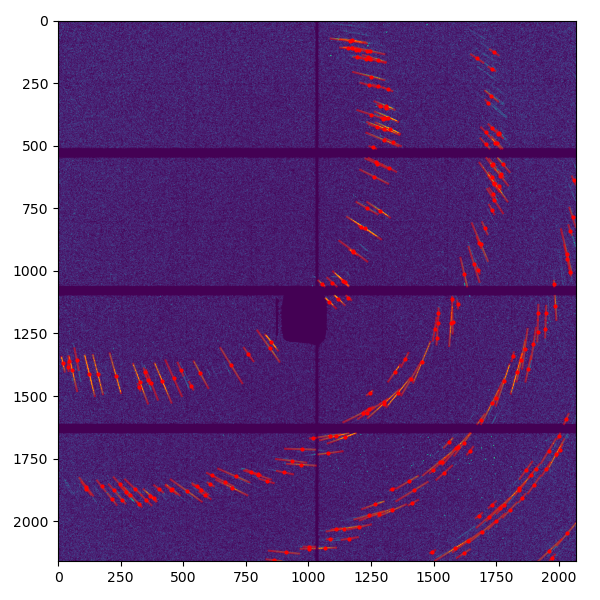

In [29]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(new_image.data[()], vmin=0, vmax=5)
for line in state.lines:
    ax.plot(line.bounds.x, line.bounds.y, c='r', alpha=0.5)
    ax.scatter(line.pixels.x0, line.pixels.y0, c='r', s=4)

ax.set_ylim(data.shape[0], 0)
ax.set_xlim(0, data.shape[1])
fig.tight_layout()
plt.show()

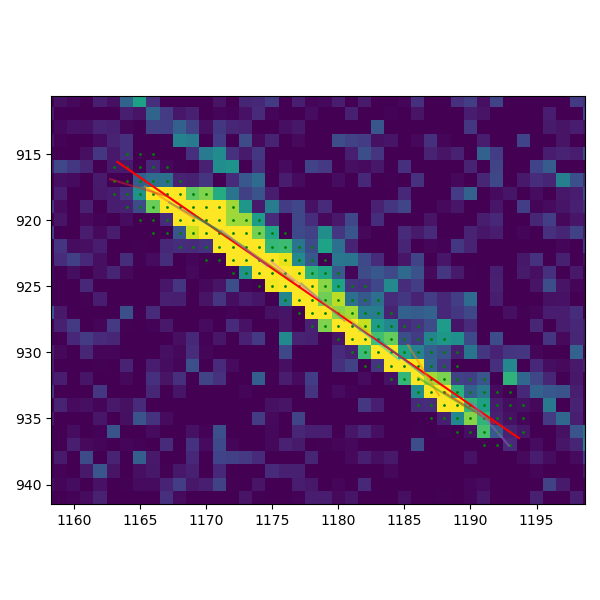

In [9]:
line = state.lines[1]
offset = 5

%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frames[index], vmin=0, vmax=10)
ax.plot(line.bounds.x, line.bounds.y, c='r')
ax.scatter(line.pixels.x, line.pixels.y, c='g', s=1)
for seed in line.linelets:
    ax.plot(seed.x, seed.y, alpha=0.5)

ax.set_ylim(max(line.bounds.y0, line.bounds.y1) + offset,
            min(line.bounds.y0, line.bounds.y1) - offset)
ax.set_xlim(min(line.bounds.x0, line.bounds.x1) - offset,
            max(line.bounds.x0, line.bounds.x1) + offset)
fig.tight_layout()
plt.show()